In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install /content/drive/MyDrive/Library/lava-dl-main.zip

In [ ]:
#!pip install wfdb

In [2]:
import sys, os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision

# import slayer from lava-dl
import lava.lib.dl.slayer as slayer
#import slayerSNN as snn


import IPython.display as display
from matplotlib import animation

In [3]:
def muriga(x,y,N,perm_a,perm_b,EARLY_EXIT):

  if EARLY_EXIT:
    x = np.moveaxis(x, perm_a, perm_b)
    # x = x[:, :, :, np.newaxis, ...]
    y = y[:]
    return [x,y]
  else:
    x = np.moveaxis(x[0:N,:,:], perm_a, perm_b)
    # x = x[:, :, :, np.newaxis, ...]
    y = y[0:N]
    new_sorted_indices = 0;

  if BALANCE:
    entries = x.shape[0]
    class_0_index = [i for i in range(entries) if (y[i] == 0).tolist() == True]
    other_index = [i for i in range(entries) if (y[i] != 0).tolist() == True]
    class_0_entries = len(class_0_index);
    new_class_0_entries = int(PERCENTAGE*class_0_entries)
    new_class_0_index = class_0_index[0:new_class_0_entries];
    new_indices = new_class_0_index+other_index
    new_sorted_indices = sorted(new_indices)
    x = x[new_sorted_indices]
    y = y[new_sorted_indices]

  if SPIKE_TIME:
    new_y = np.zeros([y.shape[0],5,x.shape[2]])
    for i,yy in enumerate(y):
      new_y[i,yy,160:198] = np.ones(38)
    y = new_y
  return [x,y,new_sorted_indices]

In [ ]:
# Unnecessary

from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import os

In [ ]:
import math

LOG_EN = True
METHOD = 'delta'

input_signals_path = [
  '/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_300/x_train.npy',
  '/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_300/x_valid.npy',
  '/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_300/x_test.npy'
]

normalize_trace = True
if normalize_trace:
  normalize_string = '_norm'
else:
  normalize_string = ''

input_signals_norm_path = [
    f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_d300/x_train_norm.npy',
    f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_d300/x_valid_norm.npy',
    f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_d300/x_test_norm.npy'
]

input_signals_d_path = [
    f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_d300/x_train_d{normalize_string}.npy',
    f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_d300/x_valid_d{normalize_string}.npy',
    f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_d300/x_test_d{normalize_string}.npy'
]

input_signals_dd_path = [
    f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_d300/x_train_dd{normalize_string}.npy',
    f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_d300/x_valid_dd{normalize_string}.npy',
    f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_d300/x_test_dd{normalize_string}.npy'
]

d_exist = True
for norm, d, dd in zip(input_signals_norm_path, input_signals_d_path, input_signals_dd_path):
  #if not os.path.exists(norm):
  if not os.path.exists(d) or not os.path.exists(dd):
    d_exist = False
    break

input_signals = [None] * 3
input_signals_norm = [None] * 3
input_signals_d = [None] * 3
input_signals_dd = [None] * 3
spike_signals_norm = [None] * 3
spike_signals_d = [None] * 3
spike_signals_dd = [None] * 3

if not d_exist:

  for s in range(len(input_signals_path)):

    input_signals[s] = np.load(input_signals_path[s]).squeeze()
    input_signals_norm[s] = np.empty((input_signals[s].shape[0], input_signals[s].shape[1]))

    if s == 0:
      trainval_min = np.min(input_signals[0])
      trainval_max = np.ptp(input_signals[0])

    #if normalize_trace:
    if True:
      input_signals_norm[s] = (input_signals[s] - trainval_min) / trainval_max
      LOG_EN and print(input_signals_norm[s].shape)
      np.save(input_signals_norm_path[s], input_signals_norm[s])

      if METHOD == 'delta':
        continue # method



    input_signals_d[s] = np.empty((input_signals[s].shape[0], input_signals[s].shape[1] - 4))
    for i in range(input_signals[s].shape[0]):
      if normalize_trace:
        input_signals_norm = (input_signals[s][i] - np.min(input_signals[s][i])) / np.ptp(input_signals[s][i])
        for j in range(input_signals[s][i].shape[0] - 4):
          input_signals_d[s][i][j] = - input_signals_norm[j] - 2 * input_signals_norm[j + 1] + 2 * input_signals_norm[j + 3] + input_signals_norm[j + 4]
      else:
        for j in range(input_signals[s][i].shape[0] - 4):
          input_signals_d[s][i][j] = - input_signals[s][i][j] - 2 * input_signals[s][i][j + 1] + 2 * input_signals[s][i][j + 3] + input_signals[s][i][j + 4]

    LOG_EN and print(input_signals_d[s].shape)
    np.save(input_signals_d_path[s], input_signals_d[s])



    input_signals_dd[s] = np.empty((input_signals_d[s].shape[0], input_signals_d[s].shape[1] - 4))
    for i in range(input_signals_d[s].shape[0]):
      if normalize_trace:
        input_signals_d_norm = (input_signals_d[s][i] - np.min(input_signals_d[s][i])) / np.ptp(input_signals_d[s][i])
        for j in range(input_signals_d[s][i].shape[0] - 4):
          input_signals_dd[s][i][j] = - input_signals_d_norm[j] - 2 * input_signals_d_norm[j + 1] + 2 * input_signals_d_norm[j + 3] + input_signals_d_norm[j + 4]
      else:
        for j in range(input_signals_d[s][i].shape[0] - 4):
          input_signals_dd[s][i][j] = - input_signals_d[s][i][j] - 2 * input_signals_d[s][i][j + 1] + 2 * input_signals_d[s][i][j + 3] + input_signals_d[s][i][j + 4]

    LOG_EN and print(input_signals_dd[s].shape)
    np.save(input_signals_dd_path[s], input_signals_dd[s])



else:
  print('Files already existing')
  for s in range(len(input_signals_path)):
    input_signals[s] = np.load(input_signals_path[s]).squeeze()

    input_signals_norm[s] = np.load(input_signals_norm_path[s])
    LOG_EN and print(input_signals_norm[s].shape)

    #input_signals_d[s] = np.load(input_signals_d_path[s])
    #LOG_EN and print(input_signals_d[s].shape)

    #input_signals_dd[s] = np.load(input_signals_dd_path[s])
    #LOG_EN and print(input_signals_dd[s].shape)

In [ ]:
# delta

delta = 0.003

spike_signals_path = [
    f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_spike_delta300/x_train_spike_{int(delta * 1000)}.npy',
    f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_spike_delta300/x_valid_spike_{int(delta * 1000)}.npy',
    f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_spike_delta300/x_test_spike_{int(delta * 1000)}.npy',
]

spike_signal = [
  np.empty((input_signals[0].shape[0], 2, input_signals[0].shape[1]), dtype=np.int8),
  np.empty((input_signals[1].shape[0], 2, input_signals[1].shape[1]), dtype=np.int8),
  np.empty((input_signals[2].shape[0], 2, input_signals[2].shape[1]), dtype=np.int8),
]

s_exist = True
for s in spike_signals_path:
  if not os.path.exists(s):
    s_exist = False
    break

if not s_exist:
  for s in range(len(input_signals_path)):
    for i in range(input_signals_norm[s].shape[0]):
      print(f'\rSet: {s + 1}/{len(input_signals_path)}   |   Step: {i + 1}/{input_signals_norm[s].shape[0]}', end = '')

      dc_val = 0
      for j in range(input_signals_norm[s].shape[1]):
        # print(input_signals_norm[s][i][j], dc_val, delta)
        # print(input_signals_norm[s][i][j] > dc_val + delta)
        if input_signals_norm[s][i][j] > dc_val + delta:
          dc_val = input_signals_norm[s][i][j]
          spike_signal[s][i][0][j] = 1
          spike_signal[s][i][1][j] = 0
        elif input_signals_norm[s][i][j] < dc_val - delta:
          dc_val = input_signals_norm[s][i][j]
          spike_signal[s][i][0][j] = 0
          spike_signal[s][i][1][j] = 1
        else:
          spike_signal[s][i][0][j] = 0
          spike_signal[s][i][1][j] = 0
      #break #
    np.save(spike_signals_path[s], spike_signal[s])
    # break #

else:
  print('Files already existing')
  for s in range(len(input_signals_path)):
    spike_signal[s] = np.load(spike_signals_path[s])

print('\nSignals shape:')
LOG_EN and print(spike_signal[0].shape)
LOG_EN and print(spike_signal[1].shape)
LOG_EN and print(spike_signal[2].shape)

In [ ]:
# sigmadelta

factor = 1
max_perc = 0.4

spike_signals_path = [
    f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_spike300/x_train_spike_{factor}_{int(max_perc * 100)}{normalize_string}.npy',
    f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_spike300/x_valid_spike_{factor}_{int(max_perc * 100)}{normalize_string}.npy',
    f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_spike300/x_test_spike_{factor}_{int(max_perc * 100)}{normalize_string}.npy',
]

new_d_len = math.floor(input_signals_d[s].shape[1] * factor)
new_dd_len = math.floor(input_signals_dd[s].shape[1] * factor)

spike_signal_f = [
  np.empty((input_signals_d[0].shape[0], 4, new_dd_len)),
  np.empty((input_signals_d[1].shape[0], 4, new_dd_len)),
  np.empty((input_signals_d[2].shape[0], 4, new_dd_len)),
]

spike_signal = [
  np.empty((input_signals_d[0].shape[0], 4, new_dd_len), dtype=np.int8),
  np.empty((input_signals_d[1].shape[0], 4, new_dd_len), dtype=np.int8),
  np.empty((input_signals_d[2].shape[0], 4, new_dd_len), dtype=np.int8),
]

def sat(en, val, min, max):
  if not en:
    return val
  if val > max:
    return max
  if val < min:
    return min
  return val

s_exist = True
for s in spike_signals_path:
  if not os.path.exists(s):
    s_exist = False
    break

if not s_exist: # or True: #
  for s in range(len(input_signals_path)):
    for i in range(input_signals_d[s].shape[0]):
      # print(f'\rSignal   |   Set: {s + 1}/{len(input_signals_path)}   |   Step: {i + 1}/{input_signals_d[s].shape[0]}', end = '')
      print(f'\rSet: {s + 1}/{len(input_signals_path)}   |   Step: {i + 1}/{input_signals_d[s].shape[0]}', end = '')
      for j in range(new_dd_len):

        new_val_d = input_signals_d[s][i][math.floor(j / factor) + 2]
        try:
          if new_val_d >= 0:
            spike_signal_f[s][i][0][j] = new_val_d
            spike_signal_f[s][i][1][j] = 0
          else:
            spike_signal_f[s][i][0][j] = 0
            spike_signal_f[s][i][1][j] = - new_val_d
        except:
          break

        new_val_dd = input_signals_dd[s][i][math.floor(j / factor)]
        try:
          if new_val_d >= 0:
            spike_signal_f[s][i][2][j] = new_val_dd
            spike_signal_f[s][i][3][j] = 0
          else:
            spike_signal_f[s][i][2][j] = 0
            spike_signal_f[s][i][3][j] = - new_val_dd
        except:
          break
      # break #

    # if s == 0:
      max_val = [
        np.max(spike_signal_f[s][i,0,:].flatten()) * max_perc,
        np.max(spike_signal_f[s][i,1,:].flatten()) * max_perc,
        np.max(spike_signal_f[s][i,2,:].flatten()) * max_perc,
        np.max(spike_signal_f[s][i,3,:].flatten()) * max_perc,
      ]
      fb_val = [0] * 4
      integ_val = [0] * 4

  # print('')
  # for s in range(len(input_signals_path)):
    # for i in range(input_signals_d[s].shape[0]):
      # print(f'\rSpike    |   Set: {s + 1}/{len(input_signals_path)}   |   Step: {i + 1}/{input_signals_d[s].shape[0]}', end = '')
      for j in range(new_dd_len):
        for k in range(4):
          integ_val[k] += sat(False, spike_signal_f[s][i][k][j], 0, max_val[k]) - fb_val[k]
          fb_val[k] = max_val[k] if integ_val[k] > 0 else 0
          spike_signal[s][i][k][j] = 1 if fb_val[k] == max_val[k] else 0
      # break #
    np.save(spike_signals_path[s], spike_signal[s])

    # if s == 2:
    #   print(f'\nMax values: {max_val}')

else:
  print('Files already existing')
  for s in range(len(input_signals_path)):
    spike_signal[s] = np.load(spike_signals_path[s])

print('Signals shape:')
LOG_EN and print(spike_signal[0].shape)
LOG_EN and print(spike_signal[1].shape)
LOG_EN and print(spike_signal[2].shape)

In [ ]:
# Unnecessary

input_signals_path = [
  '/content/drive/MyDrive/Dataset/x_train',
  '/content/drive/MyDrive/Dataset/x_valid',
  '/content/drive/MyDrive/Dataset/x_test'
]

input_signals_d_path = [
  f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_d/x_train_d{normalize_string}.npy',
  f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_d/x_valid_d{normalize_string}.npy',
  f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_d/x_test_d{normalize_string}.npy'
]

input_signals_dd_path = [
  f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_d/x_train_dd{normalize_string}.npy',
  f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_d/x_valid_dd{normalize_string}.npy',
  f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_d/x_test_dd{normalize_string}.npy'
]

input_signals = [0] * 3
for s in range(len(input_signals_path)):
  input_signals[s] = np.load(input_signals_path[s]).squeeze()
  for i in range(input_signals_dd[0][0].shape[0]):
    print('d ', '{:.3f}'.format(input_signals_d[0][0][i + 2]), '  ', end = '\t')
    for j in range(factor):
      print(spike_signal[0][0][0][i * factor + j], end = ' ')
    print('\t', end = '')
    for j in range(factor):
      print(spike_signal[0][0][1][i * factor + j], end = ' ')
    print('')

  for i in range(input_signals_dd[0][0].shape[0]):
    print('dd', '{:.3f}'.format(input_signals_dd[0][0][i]), '  ', end = '\t')
    for j in range(factor):
      print(spike_signal[0][0][2][i * factor + j], end = ' ')
    print('\t', end = '')
    for j in range(factor):
      print(spike_signal[0][0][3][i * factor + j], end = ' ')
    print('')
  break

In [ ]:
SPIKE_TIME = False
BALANCE = False
PERCENTAGE = 0.1
d = 1;

dataset_type = 'delta300'

if dataset_type == 'sigmadelta':
  xx_train = spike_signal[0]
  xx_valid = spike_signal[1]
  xx_test = spike_signal[2]
  # xx_train = np.load(f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_spike/x_train_spike_{factor}_{int(max_perc * 100)}{normalize_string}.npy')
  # xx_valid = np.load(f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_spike/x_valid_spike_{factor}_{int(max_perc * 100)}{normalize_string}.npy')
  # xx_test = np.load(f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_spike/x_test_spike_{factor}_{int(max_perc * 100)}{normalize_string}.npy')
  yy_train = np.load('/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_thermometer/y_train.npy')
  yy_valid = np.load('/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_thermometer/y_valid.npy')
  yy_test = np.load('/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_thermometer/y_test.npy')

elif dataset_type == 'delta300':
  xx_train = spike_signal[0]
  xx_valid = spike_signal[1]
  xx_test = spike_signal[2]
  # xx_train = np.load(f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_300/x_train_spike_{int(delta * 1000)}.npy')
  # xx_valid = np.load(f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_300/x_valid_spike_{int(delta * 1000)}.npy')
  # xx_test = np.load(f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_300/x_test_spike_{int(delta * 1000)}.npy')
  yy_train = np.load('/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_300/y_train.npy')
  yy_valid = np.load('/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_300/y_valid.npy')
  yy_test = np.load('/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_300/y_test.npy')

elif dataset_type == 'delta':
  xx_train = spike_signal[0]
  xx_valid = spike_signal[1]
  xx_test = spike_signal[2]
  # xx_train = np.load(f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_spike_delta/x_train_spike_{int(delta * 1000)}.npy')
  # xx_valid = np.load(f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_spike_delta/x_valid_spike_{int(delta * 1000)}.npy')
  # xx_test = np.load(f'/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_spike_delta/x_test_spike_{int(delta * 1000)}.npy')
  yy_train = np.load('/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_thermometer/y_train.npy')
  yy_valid = np.load('/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_thermometer/y_valid.npy')
  yy_test = np.load('/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_thermometer/y_test.npy')

elif dataset_type == 'normal':
  # DATASET LOADING
  xx_train = np.load('/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_thermometer/x_train_bin.npy')
  yy_train = np.load('/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_thermometer/y_train.npy')
  xx_test = np.load('/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_thermometer/x_test_bin.npy')
  yy_test = np.load('/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_thermometer/y_test.npy')
  xx_valid = np.load('/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_thermometer/x_valid_bin.npy')
  yy_valid = np.load('/content/drive/MyDrive/Dataset/mit-bih-arrhythmia-database-1.0.0_thermometer/y_valid.npy')

print('Dataset dimension')
print('x_train ' + str(xx_train.shape) + ' y_train' + str(yy_train.shape))
print('x_valid ' + str(xx_valid.shape) + ' y_valid' + str(yy_valid.shape))
print('x_test ' + str(xx_test.shape) + ' y_test' + str(yy_test.shape))
print('')

N_train = int(xx_train.shape[0]/d); N_valid = int(xx_valid.shape[0]/d); N_test = int(xx_test.shape[0]/d);

if dataset_type == 'sigma-delta' or dataset_type == 'delta' or dataset_type == 'delta300':
  perm_a = [1, 2]
  perm_b = [1, 2]

elif dataset_type == 'normal':
  perm_a = [1, 2]
  perm_b = [2, 1]

[x_train, y_train, train_idx] = muriga(xx_train, yy_train, N_train, perm_a,perm_b, False)
[x_valid, y_valid, valid_idx] = muriga(xx_valid, yy_valid, N_valid, perm_a,perm_b, False)
[x_test, y_test, test_idx] = muriga(xx_test, yy_test, N_test, perm_a,perm_b, False)

if BALANCE:
  train_label = yy_train[train_idx];
  valid_label = yy_valid[valid_idx];
  test_label = yy_test[test_idx];
else:
  train_label = yy_train[0:N_train];
  valid_label = yy_valid[0:N_valid];
  test_label = yy_test[0:N_test];

[xx_train, yy_train] = muriga(xx_train, yy_train, '', perm_a,perm_b, True)
[xx_valid, yy_valid] = muriga(xx_valid, yy_valid, '', perm_a,perm_b, True)
[xx_test, yy_test] = muriga(xx_test, yy_test, '', perm_a,perm_b, True)

print('Dataset after manipulation')
print('x_train ' + str(x_train.shape) + ' y_train' + str(y_train.shape))
print('x_valid ' + str(x_valid.shape) + ' y_valid' + str(y_valid.shape))
print('x_test ' + str(x_test.shape) + ' y_test' + str(y_test.shape))

In [ ]:
# NORMAL - NOT NORMAL
for yy in yy_train[0:100]:
  print(yy, end='')

for i in range(yy_train.shape[0]):
  if yy_train[i] != 0:
    yy_train[i] = 1

for i in range(yy_valid.shape[0]):
  if yy_valid[i] != 0:
    yy_valid[i] = 1

for i in range(yy_test.shape[0]):
  if yy_test[i] != 0:
    yy_test[i] = 1

print('')
for yy in yy_train[0:100]:
  print(yy, end='')

In [ ]:
# ONLY NOT NORMAL

In [ ]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
print(100*np.array([sum(y_train==0),sum(y_train==1),sum(y_train==2),sum(y_train==3),sum(y_train==4)])/y_train.shape[0])
print(100*np.array([sum(y_valid==0),sum(y_valid==1),sum(y_valid==2),sum(y_valid==3),sum(y_valid==4)])/y_valid.shape[0])
print(100*np.array([sum(y_test==0),sum(y_test==1),sum(y_test==2),sum(y_test==3),sum(y_test==4)])/y_test.shape[0])
print('')
print(np.array([sum(y_train==0),sum(y_train==1),sum(y_train==2),sum(y_train==3),sum(y_train==4)]))
print(np.array([sum(y_valid==0),sum(y_valid==1),sum(y_valid==2),sum(y_valid==3),sum(y_valid==4)]))
print(np.array([sum(y_test==0),sum(y_test==1),sum(y_test==2),sum(y_test==3),sum(y_test==4)]))

In [8]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        neuron_params = {
                'threshold'     : 1.25,
                'current_decay' : 0.25,
                'voltage_decay' : 0.03,
                'tau_grad'      : 0.03,
                'scale_grad'    : 3,
                'requires_grad' : True,
            }
        neuron_params_drop = {**neuron_params, 'dropout' : slayer.neuron.Dropout(p=0.05),}

        neuron_params_1 = {
                'threshold'     : 1.25,
                'current_decay' : 0.0,
                'voltage_decay' : 0.0,
                'tau_grad'      : 0.03,
                'scale_grad'    : 3,
                'requires_grad' : True,
            }
        neuron_params_drop_1 = {**neuron_params_1, 'dropout' : slayer.neuron.Dropout(p=0.05),}

        self.blocks = torch.nn.ModuleList([
                slayer.block.cuba.Dense(neuron_params_drop, 2, 64, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params_drop, 64, 128, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params_drop, 128, 64, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params, 64, 2, weight_norm=True), # 5
            ])

        # if False:
        #   for block in self.blocks:
        #     if block.delay is not None:
        #       block.delay.max_delay = 128

    def forward(self, spike):
        #for block in self.blocks:
        #    spike = block(spike)
        spike = self.blocks[0](spike)
        spike = self.blocks[1](spike)
        spike = self.blocks[2](spike)
        spike = self.blocks[3](spike)
        return spike

    def grad_flow(self, path):
        # helps monitor the gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]

        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()

        return grad

    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))

class NetworkConv(torch.nn.Module):
    def __init__(self):
        super(NetworkConv, self).__init__()

        cuba_params = {
                'threshold'     : 0.1,
                'current_decay' : 1,
                'voltage_decay' : 0.1,
                'requires_grad' : True,
            }

        neuron_params = {
                'threshold'     : 1.25,
                'current_decay' : 0.25,
                'voltage_decay' : 0.03,
                'tau_grad'      : 0.03,
                'scale_grad'    : 3,
                'requires_grad' : True,
            }
        neuron_params_drop = {**neuron_params, 'dropout' : slayer.neuron.Dropout(p=0.05),}

        neuron_params_1 = {
                'threshold'     : 1.25,
                'current_decay' : 0.0,
                'voltage_decay' : 0.0,
                'tau_grad'      : 0.03,
                'scale_grad'    : 3,
                'requires_grad' : True,
            }
        neuron_params_drop_1 = {**neuron_params_1, 'dropout' : slayer.neuron.Dropout(p=0.05),}

        self.blocks = torch.nn.ModuleList([
                slayer.block.cuba.Conv(neuron_params = cuba_params, in_features = 198, out_features =  20,  kernel_size = 5, padding=0, stride=1, weight_scale=2, weight_norm=True), #, delay=False), 16ch x 8x8
                slayer.block.cuba.Conv(neuron_params = cuba_params, in_features = 16, out_features = 20, kernel_size = 5, padding=0, stride=1, weight_scale=2, weight_norm=True), #, delay=False),  16ch x 6x6
                #slayer.block.cuba.Dense(neuron_params_drop, 256, 64, weight_norm=True, delay=False),
                #slayer.block.cuba.Dense(neuron_params_drop, 64, 128, weight_norm=True, delay=False),
                slayer.block.cuba.Dense(neuron_params_drop, 128, 64, weight_norm=True, delay=False),
                slayer.block.cuba.Dense(neuron_params, 64, 5, weight_norm=True),
            ])

    def forward(self, spike):
        #for block in self.blocks:
        #    spike = block(spike)
        # spike = self.blocks[0](spike)
        # spike = self.blocks[1](spike)
        # spike = self.blocks[2](spike)
        # spike = self.blocks[3](spike)

        for block in self.blocks:

          if isinstance(block,slayer.block.cuba.Flatten):
            spike = spike.unsqueeze(0);

          spike = block(spike)

        return spike

    def grad_flow(self, path):
        # helps monitor the gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]

        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()

        return grad

    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))

class ECG_Dataset(Dataset):
    def __init__(self, x, y):
        super(ECG_Dataset, self).__init__()
        self.input = x
        self.target = y

    def __getitem__(self, idx):
        if SPIKE_TIME:
              y_out = torch.tensor(self.target[idx].astype(np.float32))
        else:
              y_out = torch.tensor(self.target[idx]).long() #.astype(np.float32)
        return (
            torch.tensor(self.input[idx].astype(np.float32)), #.astype(np.float32),
            y_out
        )

    def __len__(self):
        return len(self.target) # just one sample for this problem

In [ ]:
trained_folder = f'/content/drive/MyDrive/Trained/ecg_spike_delta_full_delay_w300_lr1_{int(delta * 1000)}_2classes' #_full_delay

os.makedirs(trained_folder, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

net = Network().to(device)
# net = NetworkConv().to(device)
# net = torch.load(f'/content/drive/MyDrive/Trained/ecg_spike_delta_full_delay_max62test_w300_lr1_{int(delta * 1000)}' + '/network.pt', map_location=torch.device('cpu')) #'cpu'

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

training_set = ECG_Dataset(x_train,y_train)
train_loader = DataLoader(dataset=training_set, batch_size=32)
#
validation_set = ECG_Dataset(x_valid,y_valid)
validation_loader = DataLoader(dataset=validation_set, batch_size=32)
#
test_set = ECG_Dataset(x_test,y_test)
test_loader = DataLoader(dataset=test_set, batch_size=32)

if SPIKE_TIME:
  error = slayer.loss.SpikeTime(time_constant=2, filter_order=2).to(device)
  print('SpikeTime')
else:
  error = slayer.loss.SpikeRate(true_rate=0.2, false_rate=0.03, reduction='sum').to(device) # true_rate=0.7, false_rate=0.1
  print('SpikeRate')
  #error = slayer.loss.SpikeMax().to(device) # probability # mode='logsoftmax'
  #print('SpikeMax')

stats = slayer.utils.LearningStats()

if SPIKE_TIME:
  assistant = slayer.utils.Assistant(net, error, optimizer, stats)
  print('Regression')
else:
  assistant = slayer.utils.Assistant(net, error, optimizer, stats, classifier=slayer.classifier.Rate.predict)
  #assistant = slayer.utils.Assistant(net, error, optimizer, stats, classifier=slayer.classifier.MovingWindow.predict)
  print('Classification')

In [ ]:
import copy

# netcopy = copy.deepcopy(net)

net_copy = Network()
net_copy.load_state_dict(net.state_dict())

print(net_copy.blocks)
print('')
print(net_copy.blocks[0])
print('')
print(net_copy.blocks[0].delay)

In [14]:
net = net.to(torch.device('cuda'))

In [ ]:
epochs = 3000
last_save = 0

for epoch in range(epochs):
    for i, (input, label) in enumerate(train_loader): # training loop
        output = assistant.train(input, label)
        print(f'\r[Epoch {epoch:2d}/{epochs}, Sample {i}/{x_train.shape[0]}] {stats}', end='')

    # print('')
    for i, (input, label) in enumerate(validation_loader): # validation loop
        output = assistant.test(input, label)
        print(f'\r[Epoch {epoch:2d}/{epochs}, Sample {i}/{x_valid.shape[0]}] {stats}', end='')

    # print('')
    if epoch%10 == 9: # cleanup display
        print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {stats}'))
        stats_str = str(stats).replace("| ", "\n")
        print(f'[Epoch {epoch:2d}/{epochs}]\n{stats_str}')

    if stats.training.best_accuracy: # saving best model
        torch.save(net, trained_folder + '/network.pt') # .state_dict()
        last_save = epoch
        with open(trained_folder + 'best_model.txt', 'wb') as f:
          np.save(f, last_save)

    # saving last model
    with open(trained_folder + 'last_model.txt', 'wb') as f:
          np.save(f, epoch)
    torch.save(net, trained_folder + '/last_network.pt') # .state_dict()

    # update and save stats
    stats.update()
    stats.save(trained_folder + '/')
    net.grad_flow(trained_folder + '/')

    # early exit
    if last_save + 20 == epoch:
        print("Early exit")
        break

[Epoch  7/3000, Sample 214/70482] Train loss =     0.14619 (min =     0.14742)     accuracy = 0.91875 (max = 0.91694) 

In [ ]:
print(net.blocks[0].delay._parameters['delay'])
print(net.blocks[1].delay._parameters['delay'])
print(net.blocks[2].delay._parameters['delay'])

# new_tensor = torch.zeros(4, device='cuda:0', requires_grad=True)
# net.blocks[0].delay._parameters['delay'] = torch.nn.Parameter(new_tensor)

# print(net.blocks[0].delay.__dict__['_parameters']['delay'])
# print(type(net.blocks[0].delay.__dict__['_parameters']['delay']))

In [ ]:
net = net.to(torch.device('cpu'))

In [ ]:
net = net.to(torch.device('cpu'))

fig, axs = plt.subplots(4, 1, figsize=(8, 10))
bins =62

try:
  tensor1 = net.blocks[0].delay._parameters['delay']
  ffsum1 = sum(int(t) for t in tensor1)
  #[print(int(t), ',') for t in tensor1]
  axs[0].hist(tensor1.detach().numpy(), bins=bins, color='b', alpha=0.7)
  axs[0].set_title(f'Distribuzione Tensor 1 (FF# {ffsum1})')
except:
  pass

try:
  tensor2 = net.blocks[1].delay._parameters['delay']
  ffsum2 = sum(int(t) for t in tensor2)
  axs[1].hist(tensor2.detach().numpy(), bins=bins, color='r', alpha=0.7)
  axs[1].set_title(f'Distribuzione Tensor 2 (FF# {ffsum2})')
except:
  pass

try:
#if True:
  tensor3 = net.blocks[2].delay._parameters['delay']
  ffsum3 = sum(int(t) for t in tensor3)
  axs[2].hist(tensor3.detach().numpy(), bins=bins, color='g', alpha=0.7)
  axs[2].set_title(f'Distribuzione Tensor 3 (FF# {ffsum3})')
except:
  pass

try:
  combined = torch.cat((tensor1, tensor2, tensor3), 0)
  ffsum = ffsum1 + ffsum2 + ffsum3
  axs[3].hist(combined.detach().numpy(), bins=bins, color='purple', alpha=0.7)
  axs[3].set_title(f'Distribuzione Combinata (FF# {ffsum})')
except:
  pass

plt.tight_layout()
plt.show()

In [ ]:
stats.plot(figsize=(15, 5))

In [ ]:
trained_folder = f'/content/drive/MyDrive/Trained/ecg_spike_delta_full_delay_max62test_w300_lr1_{int(delta * 1000)}'

In [ ]:
# net = torch.load(trained_folder + '/network.pt', map_location=torch.device('cuda')) #'cpu'
net = torch.load(trained_folder + '/network.pt', map_location=torch.device('cpu')) #'cpu'

In [ ]:
new_tensor = torch.zeros(64, device='cuda:0', requires_grad=True)
net.blocks[0].delay._parameters['delay'] = torch.nn.Parameter(new_tensor)

new_tensor = torch.zeros(128, device='cuda:0', requires_grad=True)
net.blocks[1].delay._parameters['delay'] = torch.nn.Parameter(new_tensor)

new_tensor = torch.zeros(64, device='cuda:0', requires_grad=True)
net.blocks[2].delay._parameters['delay'] = torch.nn.Parameter(new_tensor)

net.load_state_dict(torch.load(trained_folder + '/network.pt', map_location=torch.device('cuda'))) #'cpu'

print(net.blocks[0].delay._parameters['delay'])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
error = slayer.loss.SpikeRate(true_rate=0.1, false_rate=0.03, reduction='sum').to(device)
assistant = slayer.utils.Assistant(net, error, optimizer, stats, classifier=slayer.classifier.Rate.predict)
test_set2 = ECG_Dataset(x_test,y_test)
test_loader2 = DataLoader(dataset=test_set2, batch_size=32)
for i, (input, label) in enumerate(test_loader2): # validation loop
  output = assistant.test(input, label)
  print(f'\r[Sample {i}/{x_valid.shape[0]}] {stats}', end='')

In [ ]:
import json

summary = {}

cnt = 0
cnt_t = 0
cmatrix_true = []
cmatrix_pred = []
test_set2 = ECG_Dataset(x_test,y_test)
test_loader2 = DataLoader(dataset=test_set2, batch_size=32)
for i, (input, label) in enumerate(test_loader2):
  output = net(input)
  for o, l in zip(output, label):
    output_sum = []
    for j in range(o.shape[0]):
      output_sum.append(torch.sum(o[j]).item())
    output_max_index = output_sum.index(max(output_sum))
    if output_max_index == l.item():
      cnt += 1
    cnt_t += 1
    cmatrix_true.append(l.item())
    cmatrix_pred.append(output_max_index)
  print(f'\rAcc: {(cnt / cnt_t):.5f}, Step: {i + 1}/{len(test_loader2)}', end = '')

summary['Test accuracy'] = cnt / cnt_t
with open(trained_folder + '/summary.json', 'w') as f:
    json.dump(summary, f)

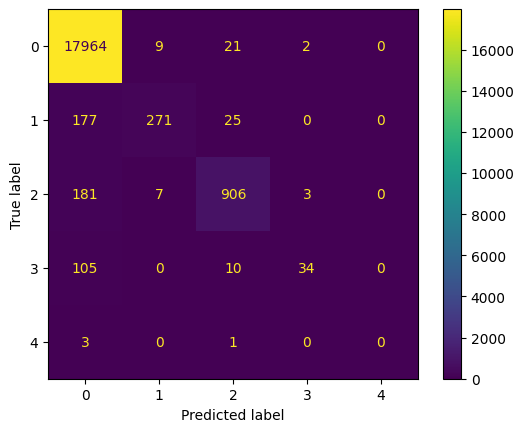

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

ConfusionMatrixDisplay.from_predictions(cmatrix_true, cmatrix_pred)
plt.savefig(trained_folder + '/cmatrix.png')
plt.show()

In [ ]:
plot_true = True
plot_false = True

ecg_class = ['N', 'S', 'V', 'F', 'Q']

if False:
  pass

else:
  nt_perclass = [20, 20, 20, 0, 0]
  # nt_perclass = [2, 2, 2, 0, 0]
  signalt_in_perclass = [[], [], [], [], []]
  signalt_out_perclass = [[], [], [], [], []]
  indext_perclass =  [[], [], [], [], []]

  nf_perclass = [20, 20, 20, 20, 0]
  # nf_perclass = [2, 2, 2, 0, 0]
  signalf_in_perclass = [[], [], [], [], []]
  signalf_out_perclass = [[], [], [], [], []]
  indexf_perclass =  [[], [], [], [], []]

  test_set2 = ECG_Dataset(x_test,y_test)
  test_loader2 = DataLoader(dataset=test_set2, batch_size=32)
  for i, (input, label) in enumerate(test_loader2):
    print(f'\rStep: {i + 1}/{len(test_loader2)}, True to find: {nt_perclass}, False to find: {nf_perclass}', end = '')
    output = net(input)

    for j, (l, o) in enumerate(zip(label, output)):
      if nt_perclass[l.item()] > 0:
        output_sum = []
        for k in range(o.shape[0]):
          output_sum.append(torch.sum(o[k]).item())
        output_max_index = output_sum.index(max(output_sum))
        if output_max_index == l.item():
          nt_perclass[l.item()] -= 1
          signalt_in_perclass[l.item()].append(input_signals_norm[2][i * 32 + j]) # input[j].detach().numpy()
          signalt_out_perclass[l.item()].append(output[j].detach().numpy())
          indext_perclass[l.item()].append((i, j))
      if nf_perclass[l.item()] > 0:
        output_sum = []
        for k in range(o.shape[0]):
          output_sum.append(torch.sum(o[k]).item())
        output_max_index = output_sum.index(max(output_sum))
        if output_max_index != l.item():
          nf_perclass[l.item()] -= 1
          signalf_in_perclass[l.item()].append(input_signals_norm[2][i * 32 + j]) # input[j].detach().numpy()
          signalf_out_perclass[l.item()].append(output[j].detach().numpy())
          indexf_perclass[l.item()].append((i, j))

    if all(j == 0 for j in nt_perclass) and all(j == 0 for j in nf_perclass):
      print(f'\rStep: {i + 1}/{len(test_loader2)}, True to find: {nt_perclass}, False to find: {nf_perclass}', end = '')
      break

if plot_true:
  for i, c in enumerate(signalt_in_perclass):
    fig, ax1 = plt.subplots(figsize=(15, 2))
    for j, s in enumerate(c):
      ax1.plot(s, 'r-') #, label=f'Signal: {j}'
    ax1.legend()
    ax1.set_title(f'True {ecg_class[i]}')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Signal')

    plt.grid(axis='y')
    plt.show()

if plot_false:
  for i, c in enumerate(signalf_in_perclass):
    fig, ax1 = plt.subplots(figsize=(15, 2))
    for j, s in enumerate(c):
      ax1.plot(s, 'b-') #, label=f'Signal: {j}'
    ax1.legend()
    ax1.set_title(f'False {ecg_class[i]}')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Signal')

    plt.grid(axis='y')
    plt.show()

In [ ]:
# normal_index = -1
# anomal_index = -1
# anomal_index_ok = -1

    # if normal_index == -1:
    #   for j, l in enumerate(label):
    #     if l.item() == 0:
    #       normal_index = j
    #       break

    # if anomal_index == -1:
    #   for j, l in enumerate(label):
    #     if l.item() != 0:
    #       anomal_index = j
    #       print('class anomal', l.item())
    #       break

    # if anomal_index_ok == -1:
    #   for j, (l, o) in enumerate(zip(label, output)):
    #     if l.item() != 0:
    #       output_sum = []
    #       for k in range(o.shape[0]):
    #         output_sum.append(torch.sum(o[k]).item())
    #         output_max_index = output_sum.index(max(output_sum))
    #         if output_max_index == l.item():
    #           anomal_index_ok = j
    #           print('class anomal ok', l.item())
    #           break

    #if normal_index != -1 and anomal_index != -1 and anomal_index_ok != -1:
    #  break
    # print('nor', label[normal_index], output[normal_index])
    # print('ano', label[anomal_index], output[anomal_index])
    # break

#normal_index = 0
#anomal_index = 2
# print(normal_index)
# print(anomal_index)
# print(anomal_index_ok)

print('')
print(index_perclass)

plot_prev = False
plot_true = False
plot_false = False

if plot_prev:
  fig, ax1 = plt.subplots(figsize=(15, 2))

  tensor = output[normal_index].detach().numpy()
  #for i in range(spike_signal[2][normal_index].shape[0]):
    # print('AAA', spike_signal[2][normal_index][i])
    #for j, s in enumerate(spike_signal[2][normal_index][i]):
  for i in range(np.array(tensor).shape[0] - 1, - 1, - 1):
    for j, s in enumerate(np.array(tensor)[i]):
      if s:
        ax1.scatter(j, -i, marker='|')

  ax1.legend()
  ax1.set_title('Normal')
  ax1.set_xlabel('Time')
  ax1.set_ylabel('Spike')

  ax2 = ax1.twinx()

  #ax2.plot(input_signals_norm[2][normal_index], 'r-', label='Altro Segnale')
  #plt.yticks(np.arange(0.4, 0.8, 0.03))
  plt.grid(axis='y')
  plt.show()

if plot_prev:
  fig, ax1 = plt.subplots(figsize=(15, 1.75))

  tensor = input[normal_index].detach().numpy()
  #for i in range(spike_signal[2][normal_index].shape[0]):
    # print('AAA', spike_signal[2][normal_index][i])
    #for j, s in enumerate(spike_signal[2][normal_index][i]):
  for i in range(np.array(tensor).shape[0] - 1, - 1, - 1):
    for j, s in enumerate(np.array(tensor)[i]):
      if s:
        ax1.scatter(j, -i, marker='|')

  ax1.legend()
  ax1.set_title('Normal')
  ax1.set_xlabel('Time')
  ax1.set_ylabel('Spike')

  ax2 = ax1.twinx()

  ax2.plot(input_signals_norm[2][normal_index], 'r-', label='Altro Segnale')
  #plt.yticks(np.arange(0.4, 0.8, 0.03))
  plt.grid(axis='y')
  plt.show()

if plot_prev:
  fig, ax1 = plt.subplots(figsize=(15, 1.75))

  tensor = output[anomal_index_ok].detach().numpy()
  #for i in range(spike_signal[2][anomal_index].shape[0]):
    #for j, s in enumerate(spike_signal[2][anomal_index][i]):
  for i in range(np.array(tensor).shape[0] - 1, - 1, - 1):
    for j, s in enumerate(np.array(tensor)[i]):
      if s:
        ax1.scatter(j, -i, marker='|')

  ax1.legend()
  ax1.set_title('Anomal')
  ax1.set_xlabel('Time')
  ax1.set_ylabel('Spike')

  ax2 = ax1.twinx()

  #ax2.plot(input_signals_norm[2][anomal_index], 'r-', label='Altro Segnale')
  #plt.yticks(np.arange(0.4, 0.8, 0.03))
  plt.grid(axis='y')
  plt.show()

if plot_prev:
  fig, ax1 = plt.subplots(figsize=(15, 2))

  tensor = input[anomal_index_ok].detach().numpy()
  #for i in range(spike_signal[2][anomal_index].shape[0]):
    #for j, s in enumerate(spike_signal[2][anomal_index][i]):
  for i in range(np.array(tensor).shape[0] - 1, - 1, - 1):
    for j, s in enumerate(np.array(tensor)[i]):
      if s:
        ax1.scatter(j, -i, marker='|')

  ax1.legend()
  ax1.set_title('Anomal')
  ax1.set_xlabel('Time')
  ax1.set_ylabel('Spike')

  ax2 = ax1.twinx()

  ax2.plot(input_signals_norm[2][anomal_index_ok], 'r-', label='Altro Segnale')
  #plt.yticks(np.arange(0.4, 0.8, 0.03))
  plt.grid(axis='y')
  plt.show()


In [ ]:
# Unnecessary

test_set2 = ECG_Dataset(xx_test,yy_test)
test_loader2 = DataLoader(dataset=test_set2, batch_size=32)
pred = torch.zeros(xx_test.shape[0])
for i, (input, label) in enumerate(test_loader2):
  output = net(input)
  count = torch.sum(output[0],dim=1)
  winner = (max(count) == count).nonzero(as_tuple=True)[0][0].item()
  pred[i] = winner
  print(f'\r[Inference {i}/{xx_test.shape[0]}]', end='')

print(torch.tensor(yy_test).shape[0], xx_test.shape[0])
test_acc = sum(torch.eq(pred, torch.tensor(yy_test)))/xx_test.shape[0];
print('')
print('valid accuracy = ' + str(test_acc))

In [ ]:
valid_set2 = ECG_Dataset(x_valid,y_valid)
valid_loader2 = DataLoader(dataset=valid_set2, batch_size=1)
pred = torch.zeros(x_valid.shape[0])
for i, (input, label) in enumerate(valid_loader2):
        output = net(input)
        count = torch.sum(output[0],dim=1)
        winner = (max(count) == count).nonzero(as_tuple=True)[0][0].item()
        pred[i] = winner
        print(f'\r[Inference {i}/{x_valid.shape[0]}]', end='')
valid_acc = sum(torch.eq(pred, torch.tensor(y_valid)))/x_valid.shape[0];
print('')
print('valid accuracy = ' + str(valid_acc))

In [ ]:
valid_set2 = ECG_Dataset(xx_valid,yy_valid)
valid_loader2 = DataLoader(dataset=valid_set2, batch_size=1)
pred = torch.zeros(xx_valid.shape[0])
for i, (input, label) in enumerate(valid_loader2):
        output = net(input)
        count = torch.sum(output[0],dim=1)
        winner = (max(count) == count).nonzero(as_tuple=True)[0][0].item()
        pred[i] = winner
        print(f'\r[Inference {i}/{xx_valid.shape[0]}]', end='')
valid_acc = sum(torch.eq(pred, torch.tensor(yy_valid)))/xx_valid.shape[0];
print('')
print('valid accuracy = ' + str(valid_acc))

In [ ]:
training_set2 = ECG_Dataset(xx_train,yy_train)
train_loader2 = DataLoader(dataset=training_set2, batch_size=1)
pred = torch.zeros(xx_train.shape[0])
for i, (input, label) in enumerate(train_loader2):
        output = net(input)
        count = torch.sum(output[0],dim=1)
        if(sum(count) == 0):
          count = torch.tensor([0,-1,-1,-1,-1])
        winner = (max(count) == count).nonzero(as_tuple=True)[0][0].item()
        pred[i] = winner
        print(f'\r[Inference {i}/{xx_train.shape[0]}]', end='')
train_acc = sum(torch.eq(pred, torch.tensor(yy_train)))/xx_train.shape[0];
print('')
print('train accuracy = ' + str(train_acc))

In [ ]:
k = 0
input = torch.tensor(x_train[k].astype(np.float32)).unsqueeze(dim=0)
label = train_label[k]

inference = net(input)

for i in range(5):
  plt.plot(net(input)[0,i].detach().numpy() + i)
plt.title('Label = ' + str(label))